# NGCF 

In [1]:
import numpy as np 
from os.path import join
from model import NGCF,NGCF_pyg
from utils import compute_laplacien
from utils import Gowalla
from torch_geometric.data import Data
import torch_geometric as pyg
import torch
from operator import itemgetter
from torch_geometric.utils import to_undirected

## Loading Datasets

In [2]:
data_path =  '/home/yannis/Documents/Recherche/Thèse/code/graph_datasets/gowalla'
data_path = '/Users/ykarmim/Documents/Recherche/Thèse/Code/graph_datasets/gowalla'

dataset = Gowalla(data_path,mode='train')


In [3]:
dataset.N

29858

In [4]:
dataset.edge_index

tensor([[    0,     0,     0,  ..., 70837, 70837, 70838],
        [29858, 29859, 29860,  ..., 29322, 29527, 29371]])

In [5]:
dataset.direct_edge_index

tensor([[    0,     0,     0,  ..., 29857, 29857, 29857],
        [29858, 29859, 29860,  ..., 31711, 30549, 30532]])

In [6]:
len(dataset.direct_edge_index[0])

810128

In [7]:
dataset.users_id

tensor([    0,     1,     2,  ..., 29855, 29856, 29857])

In [8]:
dataset.items_id

tensor([29858, 29859, 29860,  ..., 70836, 70837, 70838])

In [9]:
len(dataset.users_id)

29858

In [10]:
len(dataset.items_id) * len(dataset.users_id)

1223610698

In [11]:
len(dataset.items_id)

40981

In [12]:
dataset.items_id[-1]

tensor(70838)

In [13]:
bi = torch.Tensor(dataset.R)

In [14]:
pyg.utils.structured_negative_sampling_feasible(dataset.direct_edge_index)

True

In [19]:
sample = pyg.utils.structured_negative_sampling(dataset.direct_edge_index,num_nodes=dataset.N)

In [20]:
sample

(tensor([    0,     0,     0,  ..., 29857, 29857, 29857]),
 tensor([   0,    1,    2,  ..., 1853,  691,  674]),
 tensor([23407, 12493, 29057,  ..., 25871,  9456, 25186]))

In [22]:
from torch import Tensor 
import torch 
import numpy as np 

def maybe_num_nodes(edge_index, num_nodes=None):
    if num_nodes is not None:
        return num_nodes
    elif isinstance(edge_index, Tensor):
        return int(edge_index.max()) + 1 if edge_index.numel() > 0 else 0
    else:
        return max(edge_index.size(0), edge_index.size(1))


def structured_bipartite_negative_sampling(edge_index,n_users, num_nodes= None,contains_neg_self_loops=False):
    r"""
    Original function
    https://pytorch-geometric.readthedocs.io/en/latest/modules/utils.html#torch_geometric.utils.structured_negative_sampling
    Modified to work with bipartite graph
    
    Samples a negative edge :obj:`(i,k)` for every positive edge
    :obj:`(i,j)` in the graph given by :attr:`edge_index`, and returns it as a
    tuple of the form :obj:`(i,j,k)`.

    Args:
        edge_index (LongTensor): The edge indices.
        n_users (int): Number of users in the bipartite graph
        num_nodes (int, optional): The number of nodes, *i.e.*
            :obj:`max_val + 1` of :attr:`edge_index`. (default: :obj:`None`)
        contains_neg_self_loops (bool, optional): If set to
            :obj:`False`, sampled negative edges will not contain self loops.
            (default: :obj:`True`)

    :rtype: (LongTensor, LongTensor, LongTensor)
    """
    num_nodes = maybe_num_nodes(edge_index, num_nodes)

    row, col = edge_index.cpu()
    pos_idx = row * num_nodes + col
    if not contains_neg_self_loops:
        loop_idx = torch.arange(num_nodes) * (num_nodes + 1)
        pos_idx = torch.cat([pos_idx, loop_idx], dim=0)

    rand = torch.randint(low=n_users-1,high=num_nodes, size=(row.size(0), ),dtype=torch.long)
    print(rand.shape,rand)
    neg_idx = row * num_nodes + rand

    mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
    rest = mask.nonzero(as_tuple=False).view(-1)
    while rest.numel() > 0:  # pragma: no cover
        tmp = torch.randint(num_nodes, (rest.size(0), ), dtype=torch.long)
        rand[rest] = tmp
        neg_idx = row[rest] * num_nodes + tmp

        mask = torch.from_numpy(np.isin(neg_idx, pos_idx)).to(torch.bool)
        rest = rest[mask]

    return edge_index[0], edge_index[1], rand.to(edge_index.device)

In [23]:
sample = structured_bipartite_negative_sampling(dataset.direct_edge_index,n_users=dataset.N,num_nodes=dataset.data.num_nodes,contains_neg_self_loops=False)

/Users/ykarmim/Documents/Recherche/Thèse/Code/sota_gnn/venv/lib/python3.7/site-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


torch.Size([810128]) tensor([54516, 67376, 57009,  ..., 60924, 62577, 64449])


In [27]:
sample

(tensor([    0,     0,     0,  ..., 29857, 29857, 29857]),
 tensor([29858, 29859, 29860,  ..., 31711, 30549, 30532]),
 tensor([54516, 67376, 57009,  ..., 60924, 62577, 64449]))

In [15]:
dataset.N 

29858

In [41]:
dataset.M

40981

In [47]:
dataset.direct_edge_index

tensor([[    0,     0,     0,  ..., 29857, 29857, 29857],
        [29858, 29859, 29860,  ..., 31711, 30549, 30532]])

In [15]:
sample = pyg.utils.negative_sampling(dataset.direct_edge_index,num_nodes=(dataset.N,dataset.M),num_neg_samples=10)

In [16]:
sample

tensor([[ 6427, 28242, 10914, 25292, 22380, 22867,  2366, 13267, 29254,  9942],
        [35660, 22002,  1713, 15627, 33500,  4648,  3822, 29996,  1408, 20655]])

In [46]:
dataset.direct_edge_index

tensor([[    0,     0,     0,  ..., 29857, 29857, 29857],
        [29858, 29859, 29860,  ..., 31711, 30549, 30532]])

In [49]:
dataset.R.shape

torch.Size([29858, 40981])

In [15]:
data = dataset.data
data.has_isolated_nodes()

/Users/ykarmim/Documents/Recherche/Thèse/Code/sota_gnn/venv/lib/python3.7/site-packages/torch_geometric/data/storage.py:264: UserWarning: Unable to accurately infer 'num_nodes' from the attribute set '{'edge_index'}'. Please explicitly set 'num_nodes' as an attribute of 'data' to suppress this warning
  " to suppress this warning")


False

In [16]:
data.has_self_loops()

False

In [17]:
data.is_directed()

False

In [18]:
data.num_nodes

70839

## Model

In [19]:
model = NGCF(data.num_nodes)

In [20]:
pos_sim,neg_sim = model(sample)

In [21]:
pos_sim.size()

torch.Size([810128])

In [22]:
neg_sim.size()

torch.Size([810128])

In [25]:
len(data.edge_index[0])/2

810128.0

In [39]:
model.E1.requires_grad

True

In [20]:
output.size()

torch.Size([70839, 256])

In [21]:
output[0].size()

torch.Size([256])

In [22]:
b1 = output[:5]
b2 = output[5:10]

In [34]:
sample

(tensor([    0,     0,     0,  ..., 29857, 29857, 29857]),
 tensor([29858, 29859, 29860,  ..., 31711, 30549, 30532]),
 tensor([51270, 34765, 61993,  ..., 27217, 43488, 41777]))

In [83]:
user = sample[0][:1000]
pos = sample[1][:1000]
neg = sample[2][:1000]

print(user,pos,neg)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5,

In [84]:
user_list = itemgetter(*user)(output)
user_list = torch.stack(user_list,dim=0)

pos_list = itemgetter(*pos)(output)
pos_list = torch.stack(pos_list,dim=0)

neg_list = itemgetter(*neg)(output)
neg_list = torch.stack(neg_list,dim=0)

In [85]:
pos_sim = (user_list * pos_list).sum(dim=-1)
neg_sim = (user_list * neg_list).sum(dim=-1)

In [86]:
pos_sim

tensor([2.9031, 3.2129, 3.0057, 3.1020, 3.1489, 3.1027, 3.1210, 3.2399, 3.0490,
        3.0661, 3.1060, 2.8119, 3.1713, 2.8785, 3.0234, 3.0179, 2.8315, 2.8536,
        3.0059, 3.0798, 3.0457, 3.2355, 3.0323, 3.0760, 2.9096, 3.1580, 3.0446,
        2.8091, 2.9947, 3.1517, 2.9813, 3.0610, 3.1506, 3.1581, 3.1243, 3.0602,
        2.9430, 3.1183, 3.0935, 2.9908, 2.8802, 3.1151, 3.0200, 3.0894, 3.1915,
        3.0802, 2.9311, 3.0583, 3.1275, 3.0802, 2.8910, 3.1924, 3.0151, 3.0404,
        3.0623, 3.2126, 3.0787, 2.9117, 3.0872, 3.0829, 3.1487, 3.2332, 2.9896,
        3.0588, 2.9833, 3.1117, 3.1592, 3.1285, 3.1219, 2.9516, 2.9084, 3.1018,
        2.8899, 3.1241, 3.0895, 3.0435, 3.0796, 2.9483, 3.0119, 3.0346, 2.9736,
        3.0853, 3.0275, 2.6358, 2.8624, 2.9747, 3.1827, 2.7290, 3.0837, 2.8616,
        3.0520, 2.9682, 3.0258, 3.2494, 3.1547, 3.1276, 3.1038, 3.0330, 3.0405,
        3.1314, 2.9238, 2.9662, 2.9732, 3.0128, 2.9202, 3.1240, 3.0305, 2.8826,
        2.7313, 2.9140, 2.9487, 3.1252, 

In [87]:
neg_sim

tensor([3.0221, 2.9681, 3.0011, 3.0900, 3.0058, 3.0486, 2.8490, 3.0546, 3.0804,
        3.1724, 3.0923, 3.0495, 3.2038, 3.0153, 3.0106, 3.0145, 3.1445, 2.9426,
        2.4595, 3.0539, 3.1216, 3.1165, 3.1487, 3.0706, 2.8712, 3.0836, 2.9285,
        2.8816, 2.8315, 2.9785, 3.0794, 3.0846, 3.1389, 2.9804, 3.0973, 2.8688,
        3.1455, 2.9296, 2.6667, 2.8921, 3.1196, 3.1019, 3.1619, 3.2074, 3.0736,
        2.9966, 2.9592, 3.0211, 2.9874, 2.9368, 3.2084, 2.9892, 3.1092, 2.9661,
        3.1735, 2.9996, 3.0852, 3.1514, 3.1027, 3.0390, 2.9531, 3.1347, 2.8093,
        3.0967, 2.7798, 3.0900, 3.0224, 3.1699, 3.2084, 2.6882, 2.7749, 3.0540,
        3.2140, 3.2092, 2.8931, 3.1516, 3.2184, 3.1248, 2.9477, 3.0217, 2.9529,
        2.8577, 2.9509, 2.9088, 2.9179, 3.1857, 3.1413, 3.1246, 3.0369, 3.1288,
        3.1332, 3.2333, 2.9903, 2.8990, 3.1615, 3.1554, 2.7303, 3.1395, 2.9921,
        2.8210, 2.9090, 2.9028, 3.0302, 3.0551, 3.1648, 3.0234, 2.9877, 3.0192,
        3.1146, 2.7478, 2.8033, 3.0100, 

In [91]:
loss = - (pos_sim - neg_sim).sigmoid().log().mean()

In [92]:
print(loss)

tensor(0.6936, grad_fn=<NegBackward0>)


In [98]:
torch.norm(model.E,p=2)

tensor(11.2982, grad_fn=<NormBackward1>)

In [100]:
torch.norm(model.gc1.lin.weight,p=2)

tensor(4.6270, grad_fn=<NormBackward1>)

In [103]:
0.01*(torch.norm(model.E,p=2) + torch.norm(model.gc1.lin.weight,p=2)\
           + torch.norm(model.gc2.lin.weight,p=2) + torch.norm(model.gc3.lin.weight,p=2))

tensor(0.2519, grad_fn=<MulBackward0>)

In [97]:
output

tensor([[-5.0951e-03,  3.7545e-03, -1.8399e-03,  ..., -1.6805e-03,
         -5.4726e-04, -8.5002e-04],
        [ 1.3670e-02,  3.7673e-03,  2.0087e-03,  ..., -1.6324e-03,
         -7.2115e-04, -7.5299e-04],
        [ 2.1848e-03, -2.3924e-03, -3.5086e-04,  ..., -1.6370e-03,
         -6.2088e-04, -8.3870e-04],
        ...,
        [ 3.2347e-03,  7.0611e-03,  1.0637e-02,  ..., -2.3312e-03,
         -3.3307e-05, -8.9736e-04],
        [ 2.4834e-03,  2.5241e-03, -8.2491e-03,  ..., -1.2242e-03,
         -9.9041e-04, -6.4487e-04],
        [-1.2979e-02,  4.8993e-04,  3.2549e-03,  ..., -1.6207e-03,
         -1.9890e-04, -8.3342e-04]], grad_fn=<CatBackward0>)

In [90]:
loss / 1000

tensor(0.6936, grad_fn=<DivBackward0>)

In [77]:
torch.inner(output[user[0]],output[pos[4]])

tensor(3.1489, grad_fn=<ReshapeAliasBackward0>)

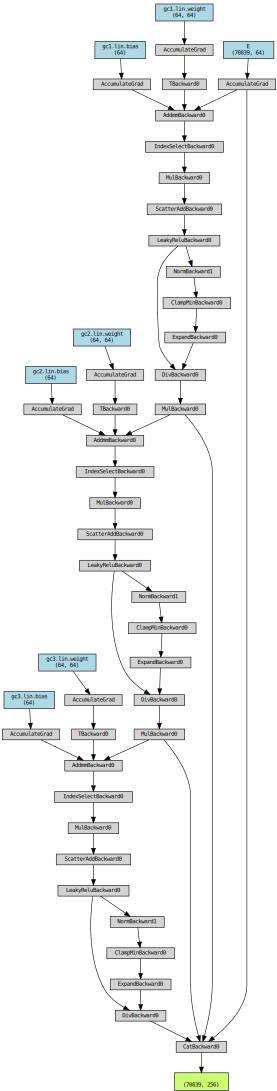

In [14]:
from torchviz import make_dot

make_dot(output, params=dict(model.named_parameters()))

In [15]:
output.size()

torch.Size([70839, 256])